In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [124]:
# Load dataset
file_path = "LBNL_file.csv"
data = pd.read_csv(file_path, low_memory=False)

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 78 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   data_provider_1                  1000000 non-null  object 
 1   data_provider_2                  1000000 non-null  object 
 2   system_ID_1                      1000000 non-null  object 
 3   system_ID_2                      1000000 non-null  object 
 4   installation_date                1000000 non-null  object 
 5   system_size_DC                   1000000 non-null  float64
 6   total_installed_price            1000000 non-null  float64
 7   rebate_or_grant                  1000000 non-null  float64
 8   customer_segment                 1000000 non-null  object 
 9   expansion_system                 1000000 non-null  int64  
 10  multiple_phase_system            1000000 non-null  int64  
 11  new_construction                 1000000 non-null  

In [126]:
data.head()

,data_provider_1,data_provider_2,system_ID_1,system_ID_2,installation_date,system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,...,built_in_meter_inverter_1,built_in_meter_inverter_2,built_in_meter_inverter_3,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,battery_rated_capacity_kW,battery_rated_capacity_kWh
0,Arkansas State Energy Office,-9999,-9999,-9999,29-Apr-2010 00:00:00,2.016,14558.0,0.0,RES,0,...,0,-9999,-9999,0.19,-9999.0,-9999.0,0,1.178947,-9999.0,-9999.0
1,Arkansas State Energy Office,-9999,-9999,-9999,26-Apr-2010 00:00:00,3.360,26096.0,0.0,RES,0,...,0,-9999,-9999,0.19,-9999.0,-9999.0,0,1.178947,-9999.0,-9999.0
2,Arkansas State Energy Office,-9999,-9999,-9999,20-Apr-2010 00:00:00,13.440,91139.0,0.0,RES,0,...,0,-9999,-9999,0.19,-9999.0,-9999.0,0,1.178947,-9999.0,-9999.0
3,Arkansas State Energy Office,-9999,-9999,-9999,21-Apr-2010 00:00:00,5.520,40043.0,0.0,RES,0,...,0,-9999,-9999,0.19,-9999.0,-9999.0,0,1.210526,-9999.0,-9999.0
4,Arkansas State Energy Office,-9999,-9999,-9999,22-Apr-2010 00:00:00,2.530,21497.0,0.0,RES,0,...,0,-9999,-9999,0.19,-9999.0,-9999.0,0,1.210526,-9999.0,-9999.0


In [127]:
# Replace -9999 with NaN
data.replace(-9999, np.nan, inplace=True)

In [128]:
# Identify and drop columns with all missing values
missing_cols = data.columns[data.isnull().all()]
print(f"Completely missing columns: {missing_cols}")
data = data.drop(columns=missing_cols)

Completely missing columns: Index(['technology_module_3', 'solar_storage_hybrid_inverter_3'], dtype='object')


In [129]:
# Separate numeric and categorical columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [130]:
# Impute missing values in numeric and categorical columns
numeric_imputer = SimpleImputer(strategy="most_frequent")
data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])

In [131]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

In [132]:
# Handle datetime columns
datetime_columns = data.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')
    data[f"{col}_days_since"] = (pd.Timestamp.now() - data[col]).dt.days
    data.drop(columns=[col], inplace=True)

In [133]:
# Label encode categorical columns
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

In [134]:
# Normalize numeric columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [135]:
# Define features and target
target_column = "battery_rated_capacity_kWh"
X = data.drop(columns=[target_column])
y = data[target_column]

In [136]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [176]:
# Define regression models
models = [
    {'name': "Random Forest", 'model': RandomForestRegressor(n_estimators=10, random_state=42)},
    {'name': "Linear Regression", 'model': LinearRegression()},
    {'name': "Decision Tree", 'model': DecisionTreeRegressor(max_depth=10)},
    {'name': "Gradient Boosting", 'model': GradientBoostingRegressor()},
    {'name': "XGBoost", 'model': XGBRegressor(force_row_wise=True)},
    {'name': "LightGBM", 'model': lgb.LGBMRegressor()},
    {'name': "SVR", 'model': SVR()}
]

In [138]:
results = {}

In [145]:
# Random Forest
model = models[0]
model_name = model['name']
model = model['model']
# Fit the model
model.fit(X_train, y_train)

# Get predictions
predictions = model.predict(X_test)

# Evaluate using MSE and R2 for regression
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Store results
results[model_name] = {"MSE": mse, "R2": r2}

In [ ]:
for i, tree in enumerate(model.estimators_):
    plt.figure(figsize=(20,10))
    plot_tree(
            tree, 
            filled=True, 
            feature_names=X_train.columns, 
            rounded=True
      )
    
    plt.savefig(f'RandomForest_tree{i}.png')
    plt.show()
    # plt.close() 

In [152]:
# Linear Regression
model = models[1]
model_name = model['name']
model = model['model']
# Fit the model
model.fit(X_train, y_train)

# Get predictions
predictions = model.predict(X_test)

# Evaluate using MSE and R2 for regression
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Store results
results[model_name] = {"MSE": mse, "R2": r2}

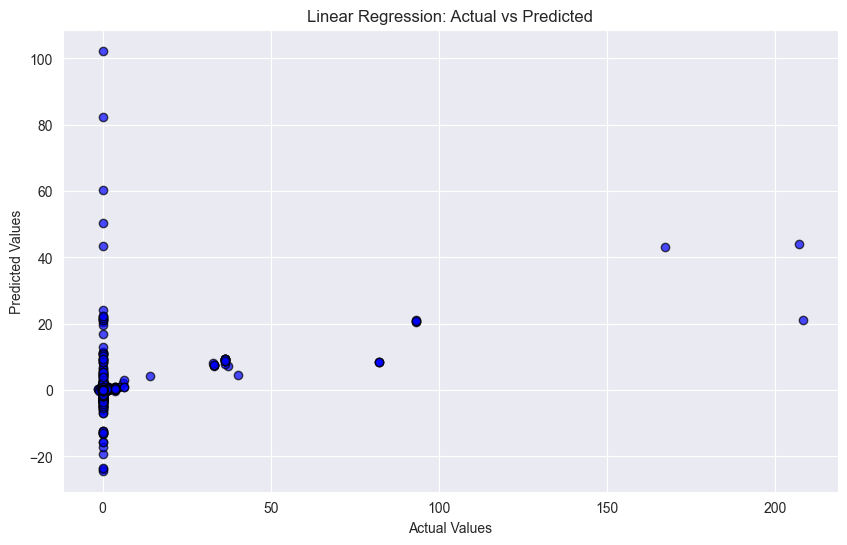

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

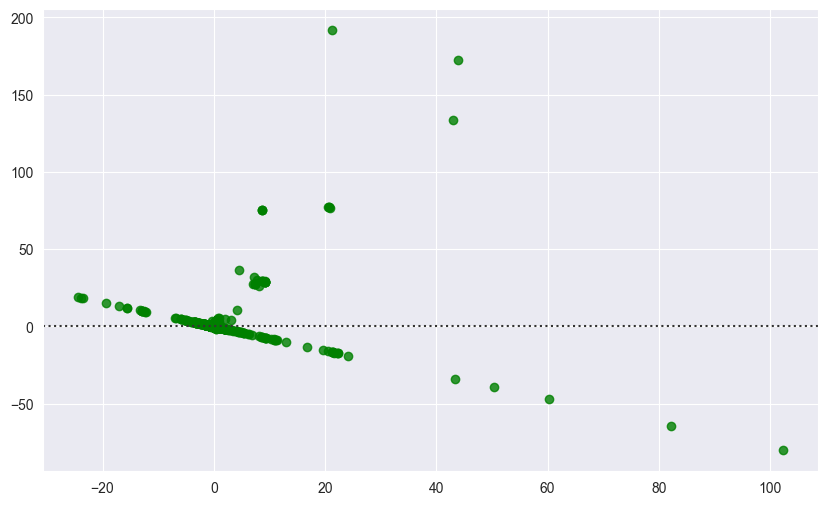

In [163]:
# Plot

# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', edgecolors='black', alpha=0.7)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, color='green', line_kws={'color': 'red'})
plt.title('Linear Regression: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6646
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 73
[LightGBM] [Info] Start training from score 0.000915
LightGBM - MSE: 0.3497630646684784, R2: 0.47289049741763445


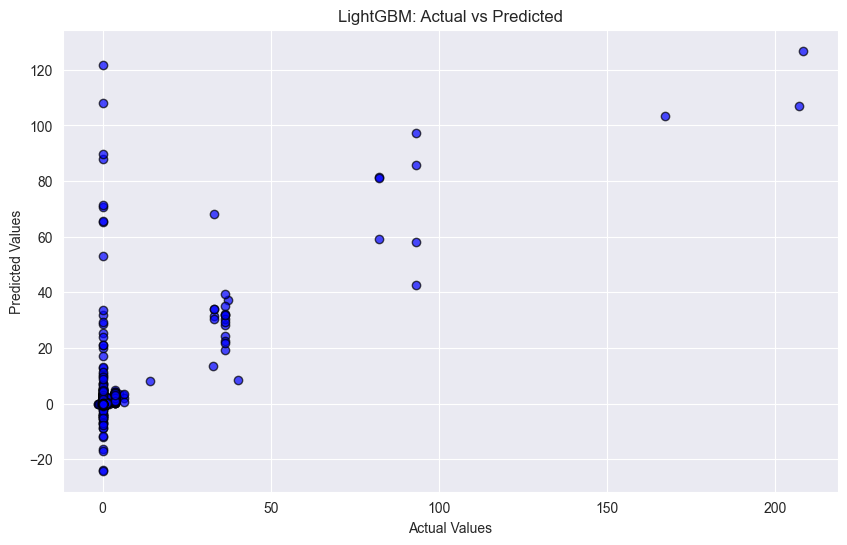

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

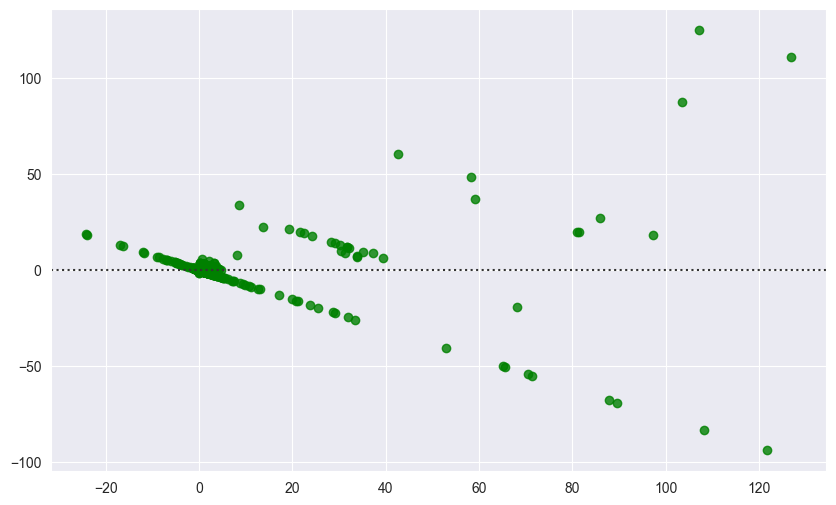

In [177]:
# LightGBM
model = models[5]
model_name = model['name']
model = model['model']
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

results[model_name] = {"MSE": mse, "R2": r2}

print(f"{model_name} - MSE: {mse}, R2: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', edgecolors='black', alpha=0.7)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, color='green', line_kws={'color': 'red'})
plt.title('LightGBM: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', edgecolors='black', alpha=0.7)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.savefig('lightgbm_actual_vs_predicted.png')

plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, color='green', line_kws={'color': 'red'})
plt.title('LightGBM: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.savefig('lightgbm_residual_plot.png')